In [28]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install bs4
from bs4 import BeautifulSoup

#!conda update -n base -c defaults conda
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


In [29]:
url='https://services.arcgis.com/1dSrzEWVQn5kHHyK/arcgis/rest/services/Administracao_Publica/FeatureServer/1/query?where=1%3D1&outFields=NOME,MORADA&outSR=4326&f=json'

In [30]:
results = requests.get(url).json()

In [31]:
JF1=pd.json_normalize(results["features"])
JF1.drop("attributes.MORADA",axis=1, inplace=True)
JF1.rename(columns={"attributes.NOME": "Neighborhood", "geometry.x":"longitude", "geometry.y":"latitude"}, inplace=True)
for k in range(0,JF1.shape[0]):
    words=JF1.loc[k,"Neighborhood"].split()
    words=words[4:len(words)]
    words=" ".join(words)
    JF1.loc[k,"Neighborhood"]=words
JF1.drop_duplicates("Neighborhood", inplace=True)
JF1.reset_index(inplace=True)
JF1.drop("index", axis=1, inplace=True)

In [32]:
JF1

,Neighborhood,longitude,latitude
0,Avenidas Novas,-9.150120,38.740142
1,São Vicente,-9.120750,38.719604
2,Penha de França,-9.126702,38.731351
3,Parque das Nações,-9.102218,38.772401
4,Santa Clara,-9.148480,38.780392
5,Santo António,-9.141489,38.720361
6,Olivais,-9.109392,38.761652
7,Ajuda,-9.199099,38.705764
8,Alcântara,-9.179188,38.705472
9,Lumiar,-9.158001,38.767706


In [33]:
url = 'https://pt.wikipedia.org/wiki/Lista_de_freguesias_de_Lisboa'
JF2=pd.read_html(url, flavor='html5lib')
JF2=JF2[0]
JF2=JF2["Freguesias atuais"][["Freguesia (Zona)[1]", "População[4]","Área(km²)[3]"]]
JF2.rename(columns={"Freguesia (Zona)[1]": "Neighborhood", "População[4]": "Population", "Área(km²)[3]": "Area (km²)"}, inplace=True)

for k in range(0,JF2.shape[0]):
    aux=JF2.loc[k,"Neighborhood"]
    index=aux.find(" (")
    aux=aux[:index]
    index=aux.find("[")
    if index !=-1:
        JF2.loc[k,"Neighborhood"]=aux[:index]
    else:
        JF2.loc[k,"Neighborhood"]=aux
        
    
    aux=JF2.loc[k,"Area (km²)"].replace("["," ")
    aux=aux.replace(",",".")
    aux=aux.split()
    aux=aux[0]
    if len(aux)==3:
        aux=str(aux[0]+"."+aux[1]+aux[2])
    JF2.loc[k,"Area (km²)"]=float(aux)
    
    aux=JF2.loc[k,"Population"]
    aux=aux.split()
    aux=int(aux[0]+aux[1])
    JF2.loc[k,"Population"]=int(aux)
    
JF2=JF2.drop_duplicates().reset_index(drop=True)

In [34]:
JF2

,Neighborhood,Population,Area (km²)
0,Ajuda,15617,2.88
1,Alcântara,13943,5.07
2,Alvalade,31813,5.34
3,Areeiro,20131,1.74
4,Arroios,31653,2.13
5,Avenidas Novas,21625,2.99
6,Beato,12737,2.46
7,Belém,16528,10.43
8,Benfica,36985,8.03
9,Campo de Ourique,22120,1.65


In [35]:
JF=JF1.merge(JF2)
JF["Density"]=JF["Population"]/JF["Area (km²)"]
JF.head(30)

,Neighborhood,longitude,latitude,Population,Area (km²),Density
0,Avenidas Novas,-9.150120,38.740142,21625,2.99,7232.44
1,São Vicente,-9.120750,38.719604,15339,1.99,7708.04
2,Penha de França,-9.126702,38.731351,27967,2.71,10319.9
3,Parque das Nações,-9.102218,38.772401,21025,5.44,3864.89
4,Santa Clara,-9.148480,38.780392,22480,3.36,6690.48
5,Santo António,-9.141489,38.720361,11836,1.49,7943.62
6,Olivais,-9.109392,38.761652,33788,8.09,4176.51
7,Ajuda,-9.199099,38.705764,15617,2.88,5422.57
8,Alcântara,-9.179188,38.705472,13943,5.07,2750.1
9,Lumiar,-9.158001,38.767706,45605,6.57,6941.4


In [36]:
with open('/resources/data/JFL.json') as json_file:
    JFL = json.load(json_file)

In [37]:
with open('JFL.json', 'w') as json_file:
    json.dump(JFL, json_file)

In [38]:
url='https://en.wikipedia.org/wiki/Lisbon#Demographics'
JF3=pd.read_html(url, flavor='html5lib')

In [39]:
JF3=JF3[3]
JF3=JF3.rename(columns={0:"Nationality", 1:"Population"})
JF3=JF3.drop([0,1])
JF3=JF3.reset_index(drop=True)
JF3=JF3.astype({'Population': 'int'})
#JF3=JF3.set_index("Nationality")

In [40]:
Afr=["Angola", "Cabo Verde", "Sao Tome and Principe", "Guinea-Bissau"]
EasternEu=["Romania", "Moldova", "Ukraine"]

JF3["Region"]=JF3["Nationality"]
for k in range(0,JF3.shape[0]):
    if JF3.loc[k,"Nationality"] in Afr:
        JF3.loc[k,"Region"]="Africa"
    if JF3.loc[k,"Nationality"] in EasternEu:
        JF3.loc[k,"Region"]="Eastern Europe"
        
JF3=JF3.drop("Nationality", axis=1)

In [41]:
JF3=JF3.groupby("Region").sum()
JF3=JF3.drop(["Germany","Netherlands", "Sweden", "United Kingdom", "Bangladesh"], axis=0)
tot=JF3.sum()[0]
JF3["Percentage"] = 100*JF3["Population"]/tot
JF3

,Population,Percentage
Region,,
Africa,50751,30.172829
Brazil,43066,25.603891
China,12493,7.427423
Eastern Europe,20957,12.459498
France,8681,5.161087
India,6490,3.858479
Italy,8840,5.255617
Nepal,7430,4.417334
Pakistan,2937,1.746125


In [42]:
Dict={"Africa": "African", "Brazil": "Brazilian", "China": "Chinese", "Eastern Europe": "EasternEurope", "France":"French", "India": "Indian", "Italy":"Italian", "Nepal": "Himalayan", "Pakistan": "Pakistani", "Spain": "Spanish"}

In [43]:
address = 'Lisbon'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_lisbon = folium.Map(location=[latitude, longitude], zoom_start=12)

map_lisbon.choropleth(
    geo_data='JFL.json',
    data=JF,
    columns=['Neighborhood', 'Density'],
    key_on='feature.attributes.NOME',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
)
    
for lat, lng, nbh in zip(JF1['latitude'], JF1['longitude'], JF1['Neighborhood']):
    label = nbh
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lisbon)  
    
map_lisbon

In [44]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row


In [45]:
CLIENT_ID = '45FQZGZSX03JOZBXSO2QPHH2LP3OJBZOKDOTL2KH5GFALCZM' # your Foursquare ID
CLIENT_SECRET = 'WA0JJBBBIUSXDUF5TRCHVF4DYT3E1IR5YPFDBYXFD1JXN5Q1' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 300
print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: 45FQZGZSX03JOZBXSO2QPHH2LP3OJBZOKDOTL2KH5GFALCZM
CLIENT_SECRET:WA0JJBBBIUSXDUF5TRCHVF4DYT3E1IR5YPFDBYXFD1JXN5Q1


In [46]:
DATAFRAME=[]

#address = 'Lisbon'
for k in range(0,JF.shape[0]):
    #geolocator = Nominatim(user_agent="foursquare_agent")
    latitude = JF.loc[k,"latitude"]
    longitude= JF.loc[k,"longitude"]
    search_query = 'Restaurant'
    radius = 1000
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    venues = results['response']['venues']
    dataframe = pd.json_normalize(venues)
    filtered_columns = ['name', 'categories']# + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
    DATAFRAME.append(dataframe_filtered)
#print(latitude, longitude)

In [47]:
H=JF3
for k in range(0,JF.shape[0]):
    #k=3
    rows=DATAFRAME[k].shape[0]
    serie=[]
    for region in list(Dict.keys()):
        soma=0
        for l in range(0,rows):
            if type(DATAFRAME[k]["categories"][l]) == str:
                if Dict[region] in DATAFRAME[k]["categories"][l]:
                    soma=soma+1
        serie.append(soma)
    H[JF.loc[k,"Neighborhood"]]=serie

In [48]:
JF3

,Population,Percentage,Avenidas Novas,São Vicente,Penha de França,Parque das Nações,Santa Clara,Santo António,Olivais,Ajuda,Alcântara,Lumiar,Santa Maria Maior,Alvalade,Arroios,Beato,Areeiro,São Domingos de Benfica,Belém,Misericórdia,Benfica,Carnide,Campo de Ourique,Campolide,Estrela,Marvila
Region,,,,,,,,,,,,,,,,,,,,,,,,,,
Africa,50751,30.172829,2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,1,0,0,0,0,2,0
Brazil,43066,25.603891,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0
China,12493,7.427423,1,1,3,1,0,1,1,2,2,2,0,0,0,0,2,4,2,0,1,4,2,0,2,0
Eastern Europe,20957,12.459498,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
France,8681,5.161087,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
India,6490,3.858479,0,3,2,1,0,3,0,1,3,0,3,0,2,0,0,0,1,3,0,0,1,1,1,0
Italy,8840,5.255617,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Nepal,7430,4.417334,0,0,3,0,0,2,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,1,0
Pakistan,2937,1.746125,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [49]:
JF4=JF3
for x in list(JF["Neighborhood"]):
    summ=JF3[x].sum()
    if not summ==0:
        JF4[x+".perc"]=JF4[x]/summ*100
    

In [50]:
JF4.drop(list(JF["Neighborhood"]),axis=1,inplace=True)

In [51]:
JF4.drop("Population",axis=1, inplace=True)

In [52]:
JF4

,Percentage,Avenidas Novas.perc,São Vicente.perc,Penha de França.perc,Parque das Nações.perc,Santo António.perc,Olivais.perc,Ajuda.perc,Alcântara.perc,Lumiar.perc,Santa Maria Maior.perc,Arroios.perc,Areeiro.perc,São Domingos de Benfica.perc,Belém.perc,Misericórdia.perc,Benfica.perc,Carnide.perc,Campo de Ourique.perc,Campolide.perc,Estrela.perc
Region,,,,,,,,,,,,,,,,,,,,,
Africa,30.172829,50.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,33.333333,14.285714,0.0,0.0,0.000000,16.666667,0.0,0.0,0.000000,0.0,25.0
Brazil,25.603891,0.0,0.0,0.000000,40.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,16.666667,0.0,0.0,0.000000,0.0,25.0
China,7.427423,25.0,25.0,33.333333,20.0,12.5,100.0,66.666667,40.0,100.0,0.000000,0.000000,100.0,100.0,66.666667,0.000000,100.0,100.0,66.666667,0.0,25.0
Eastern Europe,12.459498,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
France,5.161087,25.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
India,3.858479,0.0,75.0,22.222222,20.0,37.5,0.0,33.333333,60.0,0.0,50.000000,28.571429,0.0,0.0,33.333333,50.000000,0.0,0.0,33.333333,100.0,12.5
Italy,5.255617,0.0,0.0,11.111111,20.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
Nepal,4.417334,0.0,0.0,33.333333,0.0,25.0,0.0,0.000000,0.0,0.0,0.000000,28.571429,0.0,0.0,0.000000,16.666667,0.0,0.0,0.000000,0.0,12.5
Pakistan,1.746125,0.0,0.0,0.000000,0.0,12.5,0.0,0.000000,0.0,0.0,16.666667,14.285714,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0


In [53]:
regions=list(JF4.index)

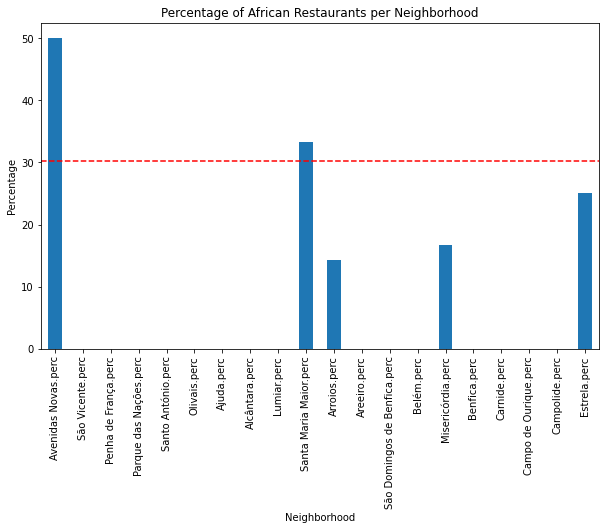

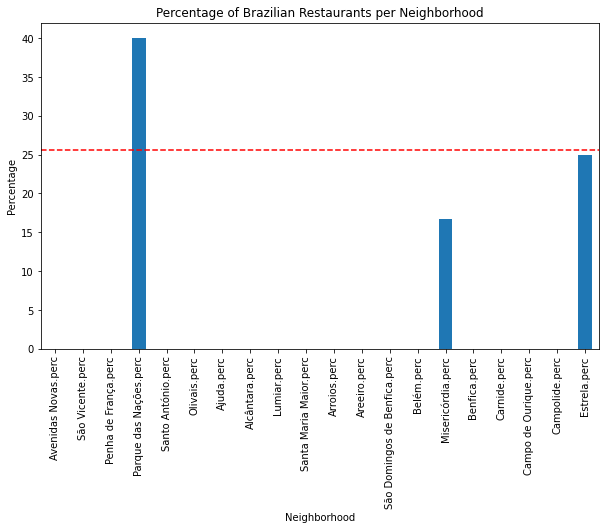

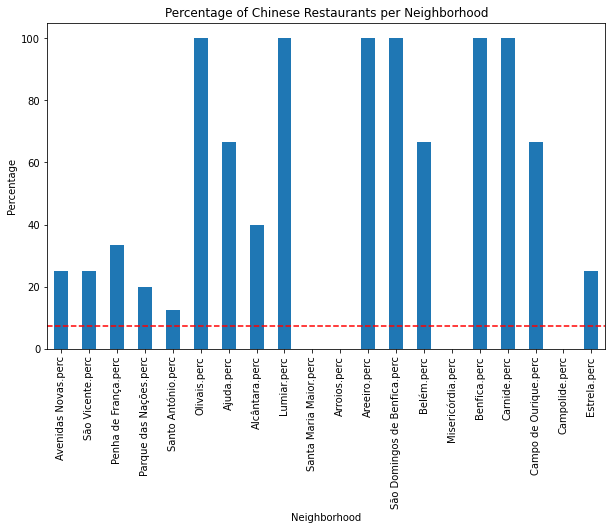

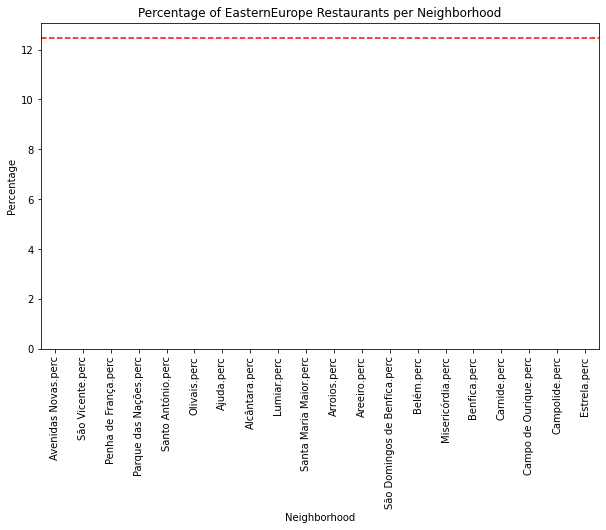

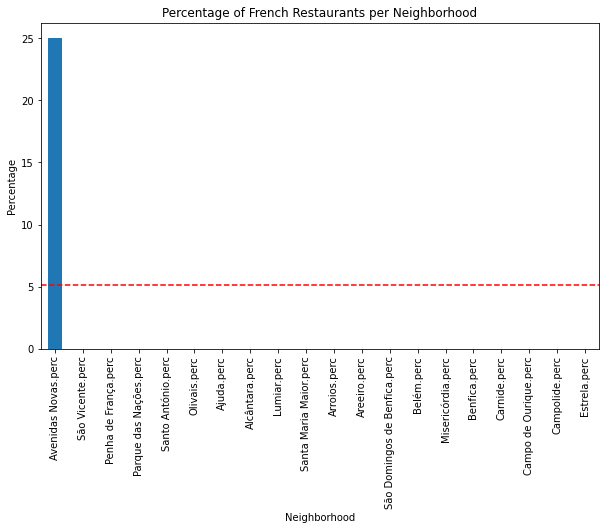

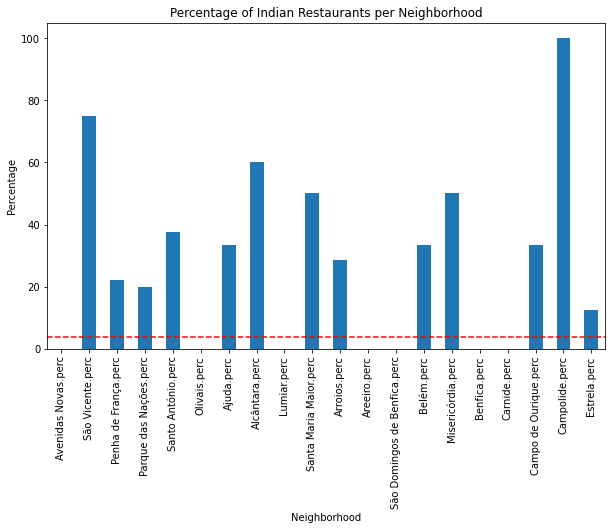

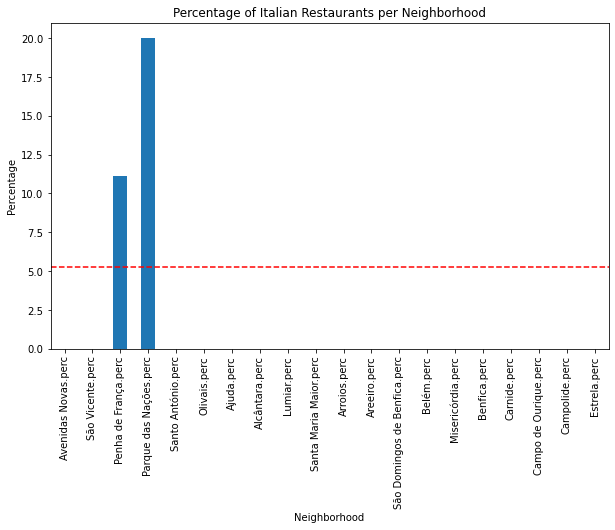

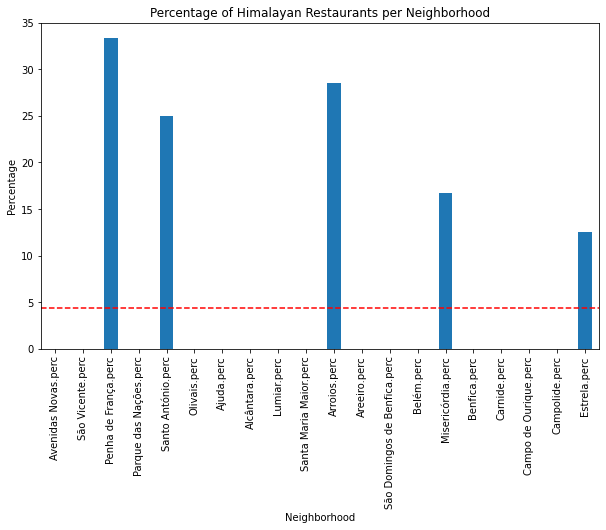

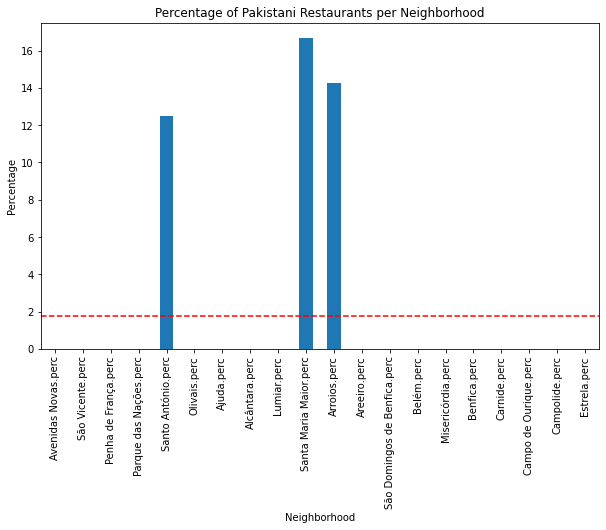

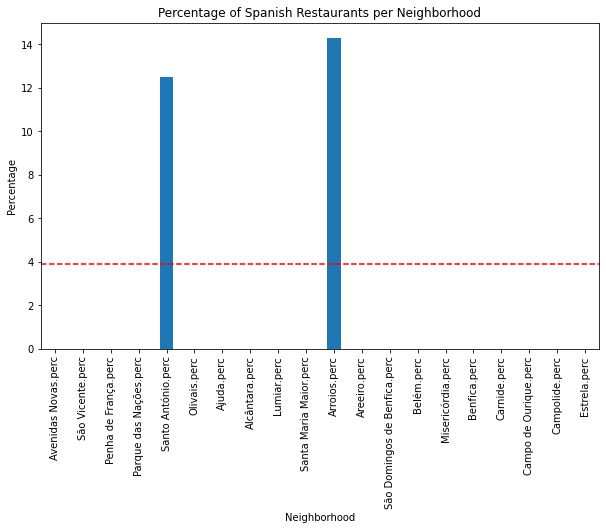

In [54]:
for x in regions:
    
    reg_perc=JF4.loc[x][0]
    region=JF4.loc[x]
    region=region[1:]

    region.plot(kind='bar', figsize=(10, 6))

    plt.xlabel('Neighborhood') # add to x-label to the plot
    plt.ylabel('Percentage') # add y-label to the plot
    plt.title('Percentage of '+ Dict[x] +' Restaurants per Neighborhood') # add title to the plot

    plt.axhline(y=reg_perc, color='r', linestyle='--')

    plt.show()